In [1]:
from bs4 import BeautifulSoup as bs
import requests
import datetime
import csv
import pandas as pd
import matplotlib.pyplot as plt

## Сбор данных

In [2]:
url = "http://stopcovid.belta.by/"
soup = bs(requests.get(url).content, "html5lib")

In [3]:
died = soup.find("div", {"data-elem-id": "1587028275158"}).text # Умерли
recovered = soup.find("div", {"field": "tn_text_1587117956904"}).text.replace(" ", "") # Выздоровели и выписаны
infected = soup.find("div", {"field": "tn_text_1587028275132"}).text.replace(" ", "") # Зарегистрированы
tested = soup.find("div", {"field": "tn_text_1587028275139"}).text.replace(" ", "") # Проведено тестов
date_pub = soup.find("div", {"field": "tn_text_1586345986707"}).text.replace(" ", "") # Дата публикации данных
time_pub = soup.find("div", {"field": "tn_text_1586345944157"}).text.strip("на ") # Время публикации
time_stamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M") # Время сбора данных со страница

In [4]:
datum = {"died": died, "recovered": recovered, "infected": infected, "tested": tested, "date_pub": date_pub, "time_pub": time_pub, "time_stamp": time_stamp}

In [5]:
with open("stopcovid_data.csv", "a") as f:
    field_names = datum.keys()
    csv_writer = csv.DictWriter(f, fieldnames=field_names)
    csv_writer.writerow(datum)

## Визуализация данных

In [6]:
plt.style.use("ggplot")
data = pd.read_csv("stopcovid_data.csv")

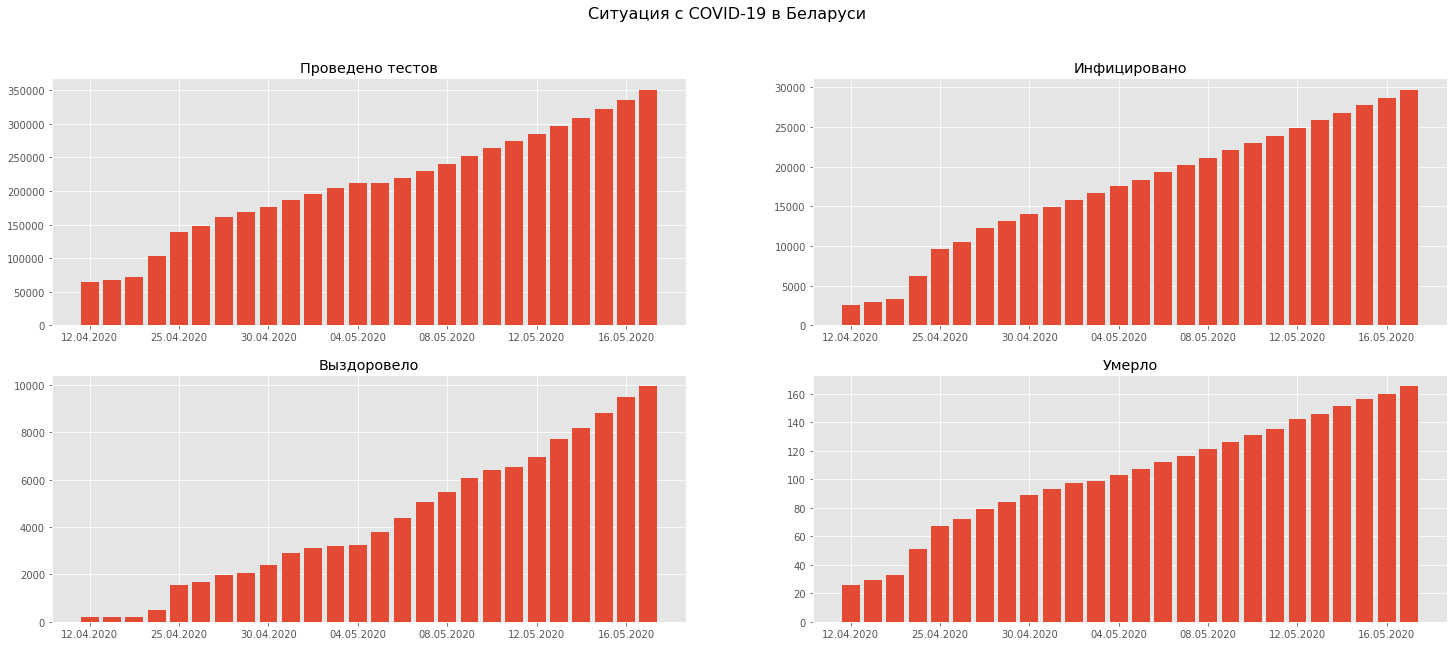

In [7]:
fig, ax = plt.subplots(2,2, figsize=(25,10));

plt.suptitle("Ситуация с COVID-19 в Беларуси", fontsize=16)

ax[0][0].bar(data["date_pub"], data["tested"]);
ax[0][0].set_ylim(0);
ax[0][0].set_title("Проведено тестов");
ax[0][0].set_xticks(data["date_pub"][::4])

ax[0][1].bar(data["date_pub"], data["infected"]);
ax[0][1].set_ylim(0);
ax[0][1].set_title("Инфицировано");
ax[0][1].set_xticks(data["date_pub"][::4]);

ax[1][0].bar(data["date_pub"], data["recovered"]);
ax[1][0].set_ylim(0);
ax[1][0].set_title("Выздоровело");
ax[1][0].set_xticks(data["date_pub"][::4]);

ax[1][1].bar(data["date_pub"], data["died"]);
ax[1][1].set_ylim(0);
ax[1][1].set_title("Умерло");
ax[1][1].set_xticks(data["date_pub"][::4]);